# Shape classification using CNN

In this notebook, we will be using the CNN architecture to train and evaluate a model that classifies simple shapes, in particular, circle square and a triangle.

Image will be used to train and test the model.


### Importing the neccessary dependancies

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image
from torch.optim import Adam
import glob



In [3]:
#check device
device = torch.device('cpu' )

## Image transformation


In [4]:
#Transforms - image
transformer=transforms.Compose([
    transforms.Resize((200,200)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

## Loading data

In [5]:
train = Path.cwd() / "dataset"/"train" #or wherever your dataset is located
test = Path.cwd() / "dataset"/"test"


In [6]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train,transform=transformer),
    batch_size=10, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test,transform=transformer),
    batch_size=10, shuffle=True
)

## Labels and Categories

In [7]:
#categories

root=Path(train)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [8]:
print(classes)

['circle', 'square', 'triangle']


## Defining the architecture 

In [9]:
#CNN Network

class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,100,100)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=100 * 100 * 32,out_features=num_classes)
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*100*100)
            
            
        output=self.fc(output)
            
        return output


## Defining the model

In [16]:
model=ConvNet(num_classes=4).to(device)

## Optmizer and loss function

In [12]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [13]:
#calculating the size of training and testing images
train_count=len(glob.glob(str(train)+'/**/*.png'))
test_count=len(glob.glob(str(test)+'/**/*.png'))

In [14]:
print(train_count,test_count)

3000 3000


## Model training and saving best model

In [15]:
#Model training and saving best model

best_accuracy=0.0
num_epochs=10

history = {
    'train_loss':[],
    'train_acc': [],
    'val_loss':[],
    'val_acc':[]
}

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    history['val_acc'].append(test_accuracy)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

C:\Users\Sizamkele Ngqwemla\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 Train Loss: tensor(7.4212) Train Accuracy: 0.8766666666666667 Test Accuracy: 0.917
Epoch: 1 Train Loss: tensor(4.3532) Train Accuracy: 0.9226666666666666 Test Accuracy: 0.941
Epoch: 2 Train Loss: tensor(2.6801) Train Accuracy: 0.9373333333333334 Test Accuracy: 0.9466666666666667
Epoch: 3 Train Loss: tensor(1.4195) Train Accuracy: 0.954 Test Accuracy: 0.9196666666666666
Epoch: 4 Train Loss: tensor(0.6050) Train Accuracy: 0.9653333333333334 Test Accuracy: 0.9446666666666667
Epoch: 5 Train Loss: tensor(0.3831) Train Accuracy: 0.9736666666666667 Test Accuracy: 0.9473333333333334
Epoch: 6 Train Loss: tensor(0.2471) Train Accuracy: 0.9776666666666667 Test Accuracy: 0.9363333333333334
Epoch: 7 Train Loss: tensor(0.1568) Train Accuracy: 0.9803333333333333 Test Accuracy: 0.9483333333333334
Epoch: 8 Train Loss: tensor(0.1387) Train Accuracy: 0.9813333333333333 Test Accuracy: 0.9423333333333334
Epoch: 9 Train Loss: tensor(0.0870) Train Accuracy: 0.9876666666666667 Test Accuracy: 0.945666

## Plotting and evaluation

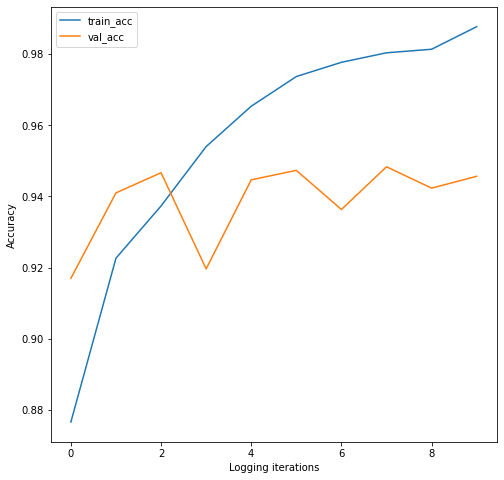

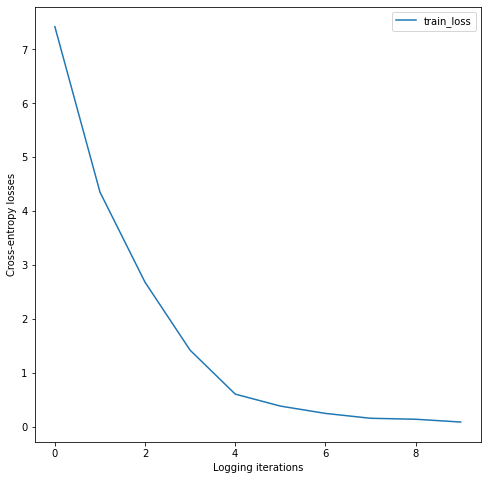

In [22]:
# You can do whatever you would like to plot results as long as it makes sense.
fig = plt.figure(figsize = (8,8))
plt.plot(history['train_acc'], label = 'train_acc')
plt.plot(history['val_acc'], label = 'val_acc')
plt.xlabel("Logging iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

fig = plt.figure(figsize = (8,8))
plt.plot(history['train_loss'], label = 'train_loss')
plt.xlabel("Logging iterations")
plt.ylabel("Cross-entropy losses")
plt.legend()
plt.show()
### END ANSWER ###